In [1]:
%matplotlib notebook
import numpy as np
import ipywidgets as widgets
import matplotlib.pyplot as plt

from mpl_toolkits import mplot3d
from datetime import datetime
from astropy.coordinates import EarthLocation
from astropy.time import Time
from astropy import units as u

In [2]:
lst, alt, az, ra, dec = np.loadtxt('data/telescope_orientation.csv', delimiter=',', unpack=True)
ha = lst - ra

<IPython.core.display.Javascript object>


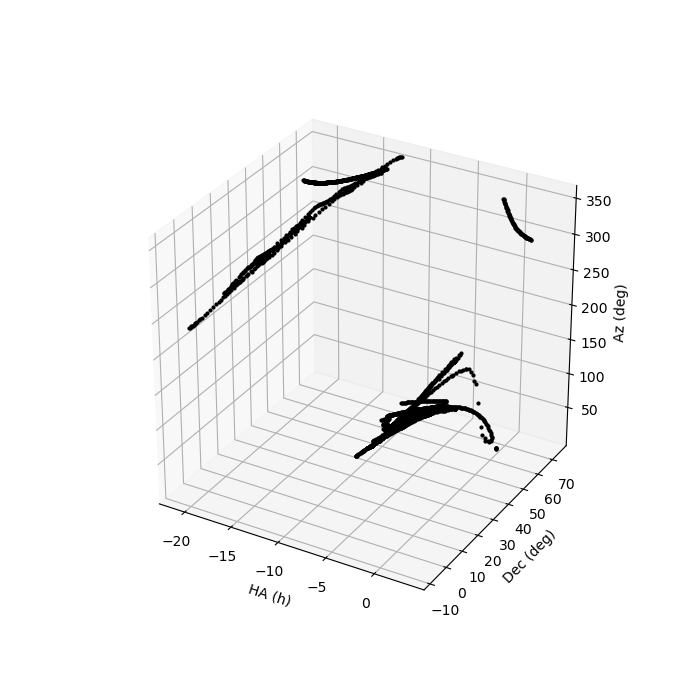

In [3]:
fig = plt.figure(figsize=(7, 7))
frame = fig.add_subplot(1, 1, 1, projection ='3d')

frame.grid(True, alpha=0.5)
# frame.set_xlim(-5, 5)
# frame.set_ylim(-5, 5)
# frame.set_zlim(0, 5)

frame.set_xlabel('HA (h)')
frame.set_ylabel('Dec (deg)')
frame.set_zlabel('Az (deg)')

plt.plot(ha, dec, az, color='black', ls='', marker='o', ms=2)
plt.show()

In [29]:
def compute_ha(ra, date):
    observing_location = EarthLocation(lat=53.240243*u.deg, lon=6.53651*u.deg) # Blaauw Observatory
    observing_time = Time(date, scale='utc', location=observing_location)
    lst = observing_time.sidereal_time('mean')
    
    print('LST = {:.5f} h'.format(lst.hour))
    
    return lst.hour - ra

## 13:17

In [30]:
ra_ex = 6 + 2 * 1/60 + 7 * 1/3600
dec_ex = 50 + 50 * 1/60
ha_ex = compute_ha(ra_ex, datetime(2021, 5, 14, hour=11, minute=17))

print('HA = {:.2f} & Dec = {:.2f}'.format(ha_ex * 15, dec_ex))

LST = 3.21393 h
HA = -42.32 & Dec = 50.83


## 13:19

In [38]:
ra_ex = 6 + 28 * 1/60 + 1 * 1/3600
dec_ex = 7 + 50 * 1/60 # deg
ha_ex = compute_ha(ra_ex, datetime(2021, 5, 14, hour=11, minute=19)) 

print('HA = {:.2f} & Dec = {:.2f}'.format(ha_ex * 15 * np.cos(np.radians(dec_ex)), dec_ex))

LST = 3.24736 h
HA = -47.84 & Dec = 7.83
